# **CIS 4190/5190 Spring 2023 - Homework 5**

**Before starting, you must click on the "Copy To Drive" option in the top bar. Go to File --> Save a Copy to Drive. This is the master notebook so <u>you will not be able to save your changes without copying it </u>! Once you click on that, make sure you are working on that version of the notebook so that your work is saved** 

In [1]:
# Restart the runtime after running this cell everytime you open the notebook
!pip install dill

In [2]:
import random 
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
from sklearn import preprocessing
np.random.seed(42)  # don't change this line

import base64

In [3]:
# For autogreader only, do not modify this cell. 
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")

[INFO, OK] Google Colab.


# **PennGrader Setup**

First, you'll need to set up the PennGrader, an autograder we are going to use throughout the semester. The PennGrader will automatically grade your answer and provide you with an instant feedback. Unless otherwise stated, you can resubmit up to a reasonable number of attempts (e.g. 100 attemptes per day). **We will only record your latest score in our backend database**. 

After finishing each homework assignment, you must submit your iPython notebook to gradescope before the homework deadline. Gradescope will then retrive and display your scores from our backend database. 

In [4]:
%%capture
!pip3 install penngrader --upgrade

In [5]:
from penngrader.grader import *

In [6]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 78803164

Run the following cell to initialize the autograder. This autograder will let you submit your code directly from this notebook and immidiately get a score.

**NOTE:** Remember we store your submissions and check against other student's submissions... so, not that you would, but no cheating.

In [7]:
grader = PennGrader(homework_id = 'CIS5190_Sp23_HW5', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 78803164

Make sure this correct or we will not be able to store your grade


In [8]:
# Serialization code needed by the autograder
import inspect, sys
from IPython.core.magics.code import extract_symbols

def new_getfile(object, _old_getfile=inspect.getfile):
    if not inspect.isclass(object):
        return _old_getfile(object)
    
    # Lookup by parent module (as in current inspect)
    if hasattr(object, '__module__'):
        object_ = sys.modules.get(object.__module__)
        if hasattr(object_, '__file__'):
            return object_.__file__
    
    # If parent module is __main__, lookup by methods (NEW)
    for name, member in inspect.getmembers(object):
        if inspect.isfunction(member) and object.__qualname__ + '.' + member.__name__ == member.__qualname__:
            return inspect.getfile(member)
    else:
        raise TypeError('Source for {!r} not found'.format(object))
inspect.getfile = new_getfile

def grader_serialize(obj):
    cell_code = "".join(inspect.linecache.getlines(new_getfile(obj)))
    class_code = extract_symbols(cell_code, obj.__name__)[0][0]
    return class_code

#### **NOTE 1. Results of sections marked as "manually graded" should be submitted along with the written homework solutions.**

#### **NOTE 2. If you are running into a `__builtins__' error, it's likely because you're using a function call of the form numpy.ndarray.mean(), like a.mean(). This does not play nice with PennGrader unfortunately. Please use the function call numpy.mean(a) instead.**

# **1. [20 pts] Image Classification using CNN**

#### **Import libraries**

In [9]:
if NOTEBOOK:
    import os
    import numpy as np
    import pandas as pd
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim
    from torchvision import transforms
    from torchvision.transforms import ToTensor
    from torch.utils.data import Dataset, DataLoader
    from PIL import Image
    import matplotlib.pyplot as plt

d:\conda\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] 找不到指定的程序。
  warn(f"Failed to load image Python extension: {e}")


#### **Set the random seed**

In [10]:
if NOTEBOOK:
    np.random.seed(0)
    torch.manual_seed(0)

#### **Set GPU**

In [19]:
torch.cuda.is_available()

True

In [12]:
# Make sure you're using cuda (GPU) by checking the hardware accelerator under Runtime -> Change runtime type
if NOTEBOOK:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("We're using:", device)

We're using: cuda


#### **Download and extract the data**

In [13]:
%%capture
if NOTEBOOK:
    !pip install -U gdown

In [14]:
if NOTEBOOK:
    !gdown 1vacRphjb47LXifcd3F2xlsOTKR0R_LiF

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vacRphjb47LXifcd3F2xlsOTKR0R_LiF
From (redirected): https://drive.google.com/uc?id=1vacRphjb47LXifcd3F2xlsOTKR0R_LiF&confirm=t&uuid=efdae887-8095-4619-b9a6-e09e79ebfc46
To: d:\Double Machine Learning\CIS519\hw5\supertuxkart_data.zip

  0%|          | 0.00/46.2M [00:00<?, ?B/s]
  9%|▉         | 4.19M/46.2M [00:00<00:01, 36.2MB/s]
 17%|█▋        | 7.86M/46.2M [00:00<00:02, 16.2MB/s]
 23%|██▎       | 10.5M/46.2M [00:00<00:02, 12.9MB/s]
 28%|██▊       | 13.1M/46.2M [00:00<00:02, 11.6MB/s]
 36%|███▋      | 16.8M/46.2M [00:01<00:02, 11.8MB/s]
 45%|████▌     | 21.0M/46.2M [00:01<00:02, 12.4MB/s]
 53%|█████▎    | 24.6M/46.2M [00:01<00:01, 12.4MB/s]
 61%|██████    | 28.3M/46.2M [00:02<00:01, 12.3MB/s]
 69%|██████▉   | 32.0M/46.2M [00:02<00:01, 12.3MB/s]
 77%|███████▋  | 35.7M/46.2M [00:02<00:00, 12.4MB/s]
 86%|████████▌ | 39.8M/46.2M [00:03<00:00, 12.7MB/s]
 93%|█████████▎| 43.0M/46.2M [00:03<00:00, 12.0MB/s]
100%|█████████▉| 46.1M

In [15]:
%%capture
if NOTEBOOK:
    !yes N | unzip "/content/supertuxkart_data.zip" -d "/content"

## **1.1. Dataset class implementation**

In this section, you will be training, validating and testing a CNN model to classify images of objects from a car racing video game called SuperTuxKart. There are 6 classes of objects: kart is 1, pickup is 2, nitro is 3, bomb is 4 and projectile 5. The background class (all other images) is assigned the label 0. First, you need to load data in a way that PyTorch can deal with easily. We will lean on PyTorch’s `Dataset` class to do this. 

Complete the `STKDataset` class that inherits from `Dataset`.

1. `__init__` is a constructor, and would be the natural place to perform operations common to the full dataset, such as parsing the labels and image paths.
2. The `__len__` function should return the size of the dataset, i.e., the number of samples.
3. The `__getitem__` function should return a python tuple of (image, label). The image should be a torch.Tensor of size (3, 64, 64) and the label should be an int.

The labels of the images under a particular folder (`train/` or `val/`) are stored in the same folder as `labels.csv`. Read the `labels.csv` file using `pandas` to understand what it looks like before proceeding. There is also a `labels.csv` in the `test/` folder. That would only contain the file names of the test samples.

In [16]:
if NOTEBOOK:
    ENCODING_TO_LABELS = {0: "background",
                        1: "kart",
                        2: "pickup",
                        3: "nitro",
                        4: "bomb",
                        5: "projectile"}

    LABELS_TO_ENCODING = {"background": 0,
                        "kart": 1,
                        "pickup": 2,
                        "nitro": 3,
                        "bomb": 4,
                        "projectile": 5}

In [27]:
if NOTEBOOK:
    
    class STKDataset(Dataset):

        def __init__(self, image_path, transform=None):
            self.image_path = image_path
            self.labels = pd.read_csv(image_path + "/labels.csv")
            self.transform = transform

        def __len__(self):
            
            # STUDENT TODO START: Return the number of samples in the dataset
            return len(self.labels)
            # STUDENT TODO END

        def __getitem__(self, idx):
            
            if torch.is_tensor(idx):
                idx = idx.tolist()

            # STUDENT TODO START: Create the path to each image by joining the root path with the name of the file as found in labels.csv
            img_name = self.image_path + '/' + self.labels['file'][idx] 
            # STUDENT TODO END

            # Read the image from the file path
            image = Image.open(img_name)
            # Transform the image using self.transform
            if self.transform:
                image = self.transform(image)

            if "label" in self.labels.columns:
                # STUDENT TODO START: Extract label name and encode it using the LABELS_TO_ENCODING dictionary
                label = LABELS_TO_ENCODING[self.labels['label'][idx]]
                # STUDENT TODO END
                sample = (image, label)
            else:
                sample = (image)
            return sample

In [28]:
if NOTEBOOK:
    # STUDENT TODO START: Use transforms.Compose to transform the image such that every pixel takes on a value between -1 and 1
    # Hint: Refer to transforms.ToTensor() and transforms.Normalize() 
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))]) 
    # STUDENT TODO END

    train_dataset = STKDataset(image_path="train", transform=transform)
    val_dataset = STKDataset(image_path="val", transform=transform)
    test_dataset = STKDataset(image_path="test", transform=transform)

#### **Visualization**

The following cell visualizes the data as a sanity check for your implementation of the `STKDataset` class.

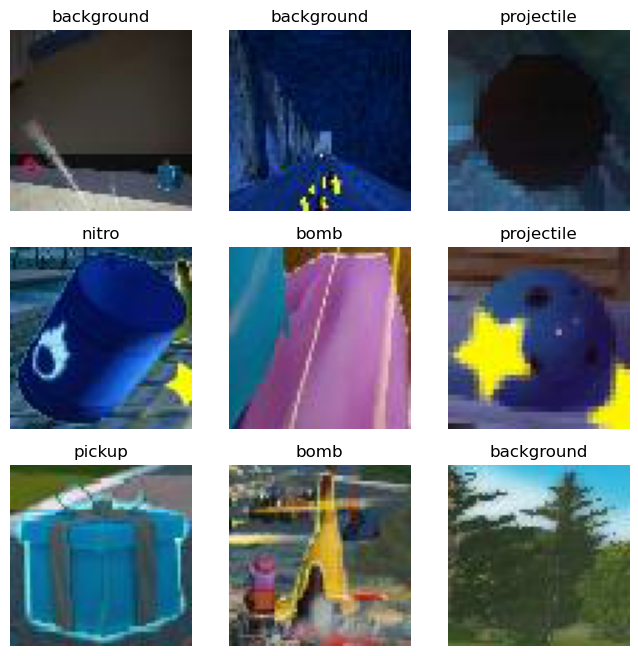

In [29]:
if NOTEBOOK:
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    torch.manual_seed(0)
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
        img, label = train_dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(ENCODING_TO_LABELS[label])
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0)*0.5 + 0.5)
    plt.show()

#### **Data loaders**

In [30]:
if NOTEBOOK:
    # STUDENT TODO START: Create data loaders for training, validation, and test sets each having a batch size of 64. 
    # Set shuffle to be True for training and validation data loaders, False for test data loader.
    train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True) 
    val_dataloader = DataLoader(val_dataset, batch_size = 64, shuffle = True) 
    test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = False) 
    # STUDENT TODO END

## **1.2. CNN architecture**

Your goal is to devise a CNN that passes the threshold accuracy (80%) on the test set. You get full score (20 pts) if you get at least 80% test set accuracy and 0 if you get 30% or below. The score varies linearly between 0 and 20 for accuracies between 30% and 80%. 

There are several decisions that you take in building your CNN including but not limited to:

- the number of convolutional layers
- the kernel size, stride, padding and number of out channels for each convolutional layer
- number of fully connected layers
- number of nodes in each fully connected layer

You are free to decide the architecture. To make your search easier, we recommend you to use not more than four convolutional layers and four fully connected layers. We also suggest that you use the relu activation function between the layers.

In [41]:
if NOTEBOOK:
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            # STUDENT TODO START: Create the layers of your CNN here
            # Convolutional layers
            self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            
            # Max pooling layers
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            
            # Fully connected layers
            self.fc1 = nn.Linear(64 * 8 * 8, 512)
            self.fc2 = nn.Linear(512, 6)

            self.dropout = nn.Dropout(0.2)
            self.softmax = nn.Softmax(dim=1)
            # STUDENT TODO END

        def forward(self, x):
            x = F.relu(self.conv1(x))
            x = self.pool(x)
            
            x = F.relu(self.conv2(x))
            x = self.pool(x)
            
            x = F.relu(self.conv3(x))
            x = self.pool(x)
            
            x = x.view(-1, 64 * 8 * 8)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)

            x = self.fc2(x)
            x = self.softmax(x)

            return x

    # STUDENT TODO START: Create an instance of Net and move it to the GPU
    model = Net().to(device) 
    # STUDENT TODO END

## **1.2. Training, validation, and testing**

In [42]:
if NOTEBOOK:
    # STUDENT TODO START: 
    # 1. Set the criterion to be cross entropy loss
    criterion = nn.CrossEntropyLoss() 

    # 2. Experiment with different optimizers
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    # STUDENT TODO END

In [37]:
 from tqdm import tqdm

In [43]:
if NOTEBOOK:

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    # STUDENT TODO START:
    # Note that we have set the number of epochs to be 10. You can choose to increase or decrease the number of epochs.
    num_epochs = 10 
    for epoch in tqdm(range(num_epochs), desc='Epochs', unit='epoch'): 
        
        model.train()
        running_loss = 0.
        correct, total = 0, 0 
        
        for i, data in enumerate(tqdm(train_dataloader, desc='Batches', unit='batch', leave=False), 0):


            inputs, labels = data
            # 1. Store the inputs and labels in the GPU
            inputs = inputs.to(device) 
            labels = labels.to(device) 
            
            # 2. Get the model predictions
            predictions = model(inputs) 

            # 3. Zero the gradients out
            optimizer.zero_grad() 

            # 4. Get the loss
            loss = criterion(predictions, labels) 

            # 5. Calculate the gradients
            loss.backward() 

            # 6. Update the weights
            optimizer.step()
                
            running_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        train_loss.append(running_loss / len(train_dataloader))
        train_acc.append(correct/total)
                
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        
        for i, data in enumerate(tqdm(val_dataloader, desc='Batches', unit='batch', leave=False), 0):

            inputs, labels = data
            # 1. Store the inputs and labels in the GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 2. Get the model predictions
            predictions = model(inputs)

            # 3. Get the loss
            loss = criterion(predictions, labels) 

            running_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        validation_loss.append(running_loss / len(val_dataloader))
        validation_acc.append(correct/total)

        print(f"Epoch {epoch+1}:")

        print(f"Training Loss:", round(train_loss[epoch], 3))
        print(f"Validation Loss:", round(validation_loss[epoch], 3))
        
        print(f"Training Accuracy:", round(train_acc[epoch], 3))
        print(f"Validation Accuracy:", round(validation_acc[epoch], 3))

        print("------------------------------")

Epochs:  10%|█         | 1/10 [00:25<03:47, 25.31s/epoch]

Epoch 1:
Training Loss: 1.637
Validation Loss: 1.745
Training Accuracy: 0.412
Validation Accuracy: 0.286
------------------------------


Epochs:  20%|██        | 2/10 [00:48<03:13, 24.23s/epoch]

Epoch 2:
Training Loss: 1.323
Validation Loss: 1.46
Training Accuracy: 0.723
Validation Accuracy: 0.576
------------------------------


Epochs:  30%|███       | 3/10 [01:13<02:50, 24.41s/epoch]

Epoch 3:
Training Loss: 1.238
Validation Loss: 1.37
Training Accuracy: 0.806
Validation Accuracy: 0.666
------------------------------


Epochs:  40%|████      | 4/10 [01:37<02:26, 24.42s/epoch]

Epoch 4:
Training Loss: 1.197
Validation Loss: 1.299
Training Accuracy: 0.847
Validation Accuracy: 0.74
------------------------------


Epochs:  50%|█████     | 5/10 [02:00<01:59, 23.88s/epoch]

Epoch 5:
Training Loss: 1.174
Validation Loss: 1.313
Training Accuracy: 0.87
Validation Accuracy: 0.727
------------------------------


Epochs:  60%|██████    | 6/10 [02:22<01:32, 23.14s/epoch]

Epoch 6:
Training Loss: 1.158
Validation Loss: 1.216
Training Accuracy: 0.886
Validation Accuracy: 0.827
------------------------------


Epochs:  70%|███████   | 7/10 [02:46<01:10, 23.35s/epoch]

Epoch 7:
Training Loss: 1.142
Validation Loss: 1.196
Training Accuracy: 0.903
Validation Accuracy: 0.848
------------------------------


Epochs:  80%|████████  | 8/10 [03:10<00:47, 23.72s/epoch]

Epoch 8:
Training Loss: 1.132
Validation Loss: 1.191
Training Accuracy: 0.912
Validation Accuracy: 0.851
------------------------------


Epochs:  90%|█████████ | 9/10 [03:32<00:22, 22.97s/epoch]

Epoch 9:
Training Loss: 1.125
Validation Loss: 1.171
Training Accuracy: 0.92
Validation Accuracy: 0.873
------------------------------


Epochs: 100%|██████████| 10/10 [03:53<00:00, 23.40s/epoch]

Epoch 10:
Training Loss: 1.116
Validation Loss: 1.182
Training Accuracy: 0.929
Validation Accuracy: 0.861
------------------------------


In [44]:
if NOTEBOOK:

    model.eval()

    test_predictions = np.array([])

    for i, data in enumerate(test_dataloader, 0):

        inputs = data
        # STUDENT TODO START:
        # 1. Store the inputs in the GPU
        inputs = inputs.to(device) 
        
        # 2. Get the model predictions
        predictions = model(inputs) 
        # STUDENT TODO END
    
        _, predicted = torch.max(predictions, 1)

        test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))

In [45]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_cnn_predictions', answer = test_predictions)

Correct! You earned 20/20 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Download the .ipynb notebook and submit on Gradescope.